# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [0]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


#### **1.2** Import necessary libraries

In [0]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
!pip install spacy==3.7.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.1/183.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.4/922.4 kB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.3/780.3 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the ke

In [0]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.1 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [0]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [0]:
# define a function to load json file to a dataframe
import json
import pandas as pd

def load_json_dataframe(file_path):
    try:
        with open(file_path, "r") as f:
            data = json.load(f)

        df = pd.DataFrame(data)
        return df
    
    except Exception as e:
        print("Error loading JSON file:", e)
        return None


##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [0]:
# read the json file by giving the file path and create a dataframe
file_path = "/Workspace/Users/rubalpreet.kaur@oportun.com/ingredient_and_quantity.json"
df = load_json_dataframe(file_path)

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [0]:
# display first five rows of the dataframe - df
display(df.head())

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [0]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [0]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [0]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df["input_tokens"] = df["input"].apply(lambda x: x.split())

# Tokenize POS
df["pos_tokens"] = df["pos"].apply(lambda x: x.split())

In [0]:
# display first five rows of the dataframe - df
display(df.head())


,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [0]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df["input_length"] = df["input_tokens"].apply(len)
df["pos_length"] = df["pos_tokens"].apply(len)

In [0]:
# check for the equality of input_length and pos_length in the dataframe
df["length_match"] = df["input_length"] == df["pos_length"]
display(df.head())
df["length_match"].value_counts()

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34,True
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37,True
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient qu

True     280
False      5
Name: length_match, dtype: int64

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [0]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it

def unique_labels(df, pos_col="pos_tokens"):
    labels = set()
    for tags in df[pos_col]:
        labels.update(tags)
    return sorted(labels)

# Use the function and print labels
labels = unique_labels(df)
print("Unique POS labels in the dataset:")
print(labels)


Unique POS labels in the dataset:
['ingredient', 'quantity', 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>
need to check the rows where input_tokens and pos_tokens


In [0]:
bad_indexes = df.index[~df["length_match"]].tolist()
print(bad_indexes)

[17, 27, 79, 164, 207]


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [0]:
# drop the irrelevant recipe data
df_clean = df[df["length_match"]].copy()
df_clean.reset_index(drop=True, inplace=True)

print("Shape before cleaning:", df.shape)
print("Shape after cleaning:", df_clean.shape)

Shape before cleaning: (285, 7)
Shape after cleaning: (280, 7)


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [0]:
# update the input and pos length in input_length and pos_length
df_clean["input_length"] = df_clean["input_tokens"].apply(len)
df_clean["pos_length"] = df_clean["pos_tokens"].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [0]:
# validate the input length and pos length as input_length and pos_length
length_match_after = (df_clean["input_length"] == df_clean["pos_length"])
print(length_match_after.value_counts())

True    280
dtype: int64


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [0]:

data_df = df_clean

train_df, val_df = train_test_split(
    data_df,
    test_size=0.3, 
    random_state=42,   
    shuffle=True
)

print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)

Train shape: (196, 7)
Val shape: (84, 7)


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [0]:
# print the first five rows of train_df
display(train_df.head())

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
175,250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
55,200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,"[200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]",41,41,True
109,500 grams Cabbage Patta Gobi Muttaikose 1 teaspoon Mustard seeds 1-1/2 White Urad Dal Split sprig Curry leaves Green Chilli 1/4 cup Fresh coconut Salt,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",25,25,True
213,500 grams Fresh Figs 1/4 cup Lemon juice 1 teaspoon zest 2 Red Chilli flakes 1/2 Honey Brown Sugar (Demerara Sugar),quantity unit ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient,"[500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]","[quantity, unit, ingredient, ingredient, quantity, unit,

In [0]:
# print the first five rows of the val_df
display(val_df.head())

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
33,1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi,quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient,"[1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,15,True
108,1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi Pods/Seeds Cumin Jeera,quantity ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",56,56,True
240,1 tablespoon Sunflower Oil 3 Potato Aloo Ginger paste Green Chilli chopped 1-1/12 tablespoons Sesame seeds Til teaspoon Red powder Cumin Jeera Coriander Powder Dhania 1/2 Garam masala 2 Sweet Chutney Date Tamarind Leaves few,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient,"[1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",35,35,True
259,1 cup green peas gram flour 1/2 cheese tsp ginger 2 chillies turmeric powder cumin teaspoon salt oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient unit ingr

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [0]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df["input_tokens"].tolist()
y_train = train_df["pos_tokens"].tolist()

X_val = val_df["input_tokens"].tolist()
y_val = val_df["pos_tokens"].tolist()

print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

196
196
84
84


In [0]:
# validate the shape of training and validation samples
print(len(X_train) == len(y_train))
print(len(X_val) == len(y_val))

True
True


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [0]:
# Display the number of unique labels present in y_train
def get_unique_labels(sequences):
    labels = set()
    for seq in sequences:
        labels.update(seq)
    return sorted(labels)

unique_y_train_labels = get_unique_labels(y_train)
print(unique_y_train_labels)
print(len(unique_y_train_labels))

['ingredient', 'quantity', 'unit']
3


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [0]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

flat_X_train = flatten_list(X_train)
flat_y_train = flatten_list(y_train)

In [0]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [0]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(dataframe, dataset_name="Dataset"):

    nested_inputs = dataframe["input_tokens"].tolist()
    nested_pos = dataframe["pos_tokens"].tolist()
    
    flat_inputs = flatten_list(nested_inputs)
    flat_pos = flatten_list(nested_pos)
    
    print(len(flat_inputs))
    print(len(flat_pos))
    print(len(flat_inputs) == len(flat_pos))
    
    print("First 10 input tokens:")
    print(flat_inputs[:10])
    
    print("First 10 POS tokens:")
    print(flat_pos[:10])
    
    return flat_inputs, flat_pos


flat_train_inputs, flat_train_pos = extract_and_validate_tokens(train_df, "Training")
flat_val_inputs, flat_val_pos = extract_and_validate_tokens(val_df, "Validation")



7114
7114
True
First 10 input tokens:
['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
First 10 POS tokens:
['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']
2876
2876
True
First 10 input tokens:
['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']
First 10 POS tokens:
['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']


In [0]:
# extract the tokens and its pos tags
train_token_pos_pairs = list(zip(flat_train_inputs, flat_train_pos))
val_token_pos_pairs = list(zip(flat_val_inputs, flat_val_pos))
print(train_token_pos_pairs[:10])
print(val_token_pos_pairs[:10])

[('250', 'quantity'), ('grams', 'unit'), ('Okra', 'ingredient'), ('Oil', 'ingredient'), ('1', 'quantity'), ('Onion', 'ingredient'), ('finely', 'ingredient'), ('chopped', 'ingredient'), ('Tomato', 'ingredient'), ('Grated', 'ingredient')]
[('1', 'quantity'), ('cup', 'unit'), ('Ada', 'ingredient'), ('2', 'quantity'), ('liter', 'unit'), ('Milk', 'ingredient'), ('3/4', 'quantity'), ('Sugar', 'ingredient'), ('tablespoon', 'unit'), ('Ghee', 'ingredient')]


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [0]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

from collections import Counter

def categorize_tokens(tokens, pos_tags):
    if len(tokens) != len(pos_tags):
        print("Length mismatch")
        return [], [], []
    
    allowed_labels = {"ingredient", "unit", "quantity"}
    unique_labels = set(tag.lower() for tag in pos_tags)
    
    if not unique_labels.issubset(allowed_labels):
        print("Unexpected labels found:", unique_labels - allowed_labels)
        return [], [], []
    
    ingredients = []
    units = []
    quantities = []
    
    for tok, lab in zip(tokens, pos_tags):
        lab = lab.lower()
        if lab == "ingredient":
            ingredients.append(tok)
        elif lab == "unit":
            units.append(tok)
        elif lab == "quantity":
            quantities.append(tok)
    
    return ingredients, units, quantities


In [0]:
#  call the function to categorise the labels into respective list
ingredients_train, units_train, quantities_train = categorize_tokens(
    flat_train_inputs,
    flat_train_pos
)

print(len(ingredients_train))
print(len(units_train))
print(len(quantities_train))

5323
811
980


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [0]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, pos_label, dataset_name="Dataset", top_n=10):
    if not item_list:
        print(f"No items found for label '{pos_label}' in {dataset_name}.")
        return []
    
    counter = Counter(item_list)
    top_items = counter.most_common(top_n)
    
    print(f"\nTop {top_n} {pos_label}s in {dataset_name}:")
    for item, cnt in top_items:
        print(f"{item}: {cnt}")
    
    return top_items


In [0]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients_train = get_top_frequent_items(
    ingredients_train, pos_label="ingredient", dataset_name="Training", top_n=10
)


Top 10 ingredients in Training:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65


In [0]:
# get the top units which are frequently seen in the recipe
top_units_train = get_top_frequent_items(
    units_train, pos_label="unit", dataset_name="Training", top_n=10
)


Top 10 units in Training:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [0]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
import matplotlib.pyplot as plt

def plot_top_items(top_items, pos_label, dataset_name="Dataset"):
    if not top_items:
        print(f"No items to plot for label '{pos_label}' in {dataset_name}.")
        return
    
    items, counts = zip(*top_items)
    
    plt.figure(figsize=(10, 5))
    plt.bar(items, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top {len(top_items)} {pos_label}s in {dataset_name}")
    plt.xlabel(f"{pos_label.capitalize()}s")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



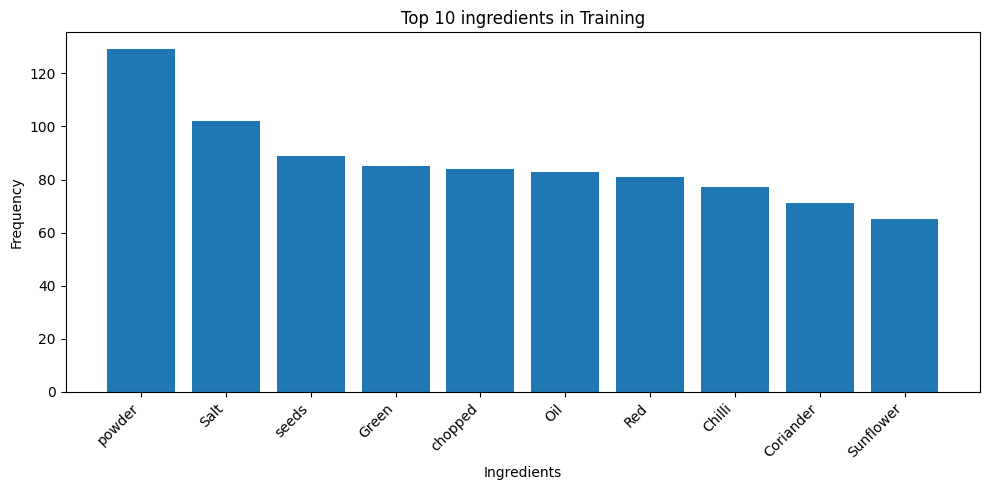

In [0]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients_train, pos_label="ingredient", dataset_name="Training")

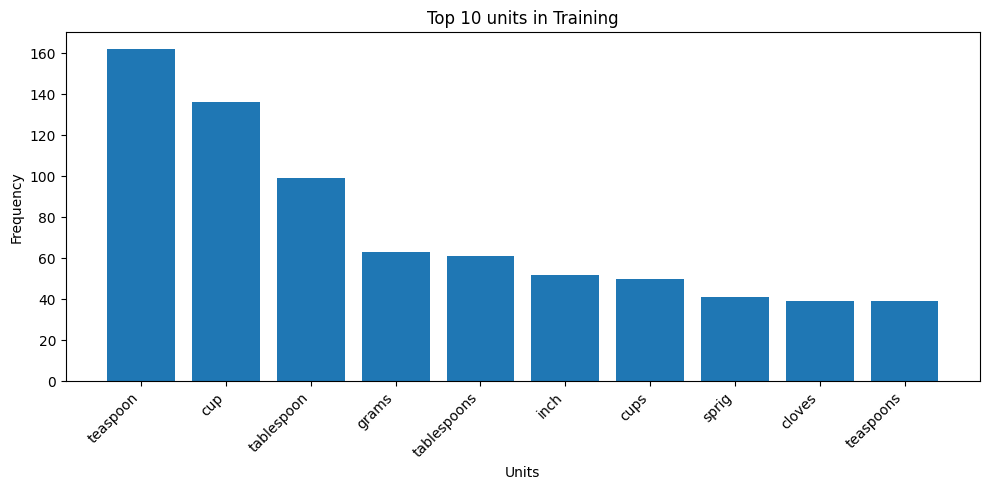

In [0]:
# plot the top frequent units in training data
plot_top_items(top_units_train,       pos_label="unit",       dataset_name="Training")

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [0]:
# initialise the dataset_name


In [0]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [0]:
# plot the top frequent ingredients in validation data


In [0]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [0]:
# define unit and quantity keywords along with quantity pattern
import re
import spacy

unit_keywords = {
    "cup", "cups", "tbsp", "tablespoon", "tablespoons",
    "tsp", "teaspoon", "teaspoons",
    "gram", "grams", "g", "kg",
    "ml", "milliliter", "milliliters", "l", "liter", "liters", "ltr",
    "ounce", "ounces", "oz",
    "clove", "cloves",
    "slice", "slices",
    "pinch", "pinches",
    "sprig", "sprigs",
    "piece", "pieces",
    "stick", "sticks"
}

quantity_keywords = {
    "half", "quarter", "third", "fourth",
    "one", "two", "three", "four", "five", "six",
    "seven", "eight", "nine", "ten",
    "dozen", "few", "couple"
}

quantity_pattern = re.compile(r"""
    ^(
        \d+(\.\d+)?      # 1, 2, 2.5
        |
        \d+/\d+          # 1/2, 3/4
        |
        \d+-\d+/\d+      # 1-1/2, 2-3/4
    )$
""", re.VERBOSE)




In [0]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")
def spacy_process_sentence(sent):
    text = " ".join(sent)
    return nlp(text)

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [0]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

def word2features(sent, i):
    token_text = sent[i]
    token_lower = token_text.lower()

    # Process the entire sentence with spaCy
    doc = spacy_process_sentence(sent)
    spacy_token = doc[i] if i < len(doc) else None

    # Core Features
    features = {
        "bias": 1.0,
        "token": token_lower,
    }

    if spacy_token is not None:
        features.update({
            "lemma": spacy_token.lemma_.lower(),
            "pos_tag": spacy_token.pos_,
            "tag": spacy_token.tag_,
            "dep": spacy_token.dep_,
            "shape": spacy_token.shape_,
            "is_stop": spacy_token.is_stop,
            "is_punct": spacy_token.is_punct,
        })
    else:
        # Fallback if spaCy token doesn't align
        features.update({
            "lemma": token_lower,
            "pos_tag": "X",
            "tag": "X",
            "dep": "dep_unknown",
            "shape": "shape_unknown",
            "is_stop": False,
            "is_punct": all(not ch.isalnum() for ch in token_text),
        })

    is_digit = token_text.isdigit()
    has_digit = any(ch.isdigit() for ch in token_text)
    has_alpha = any(ch.isalpha() for ch in token_text)
    hyphenated = "-" in token_text
    slash_present = "/" in token_text
    is_title = token_text.istitle()
    is_upper = token_text.isupper()

    features.update({
        "is_digit": is_digit,
        "has_digit": has_digit,
        "has_alpha": has_alpha,
        "hyphenated": hyphenated,
        "slash_present": slash_present,
        "is_title": is_title,
        "is_upper": is_upper,
    })

    #Improved Quantity & Unit Detection
    is_fraction = bool(re.match(r"^\d+/\d+$", token_text))
    is_decimal = bool(re.match(r"^\d+\.\d+$", token_text))
    is_numeric_pattern = bool(quantity_pattern.match(token_text))

    is_quantity_kw = token_lower in quantity_keywords
    is_unit_kw = token_lower in unit_keywords

    is_quantity = is_numeric_pattern or is_quantity_kw
    is_unit = is_unit_kw
    is_numeric = is_numeric_pattern or is_digit or is_decimal or is_fraction

    features.update({
        "is_quantity": is_quantity,
        "is_unit": is_unit,
        "is_numeric": is_numeric,
        "is_fraction": is_fraction,
        "is_decimal": is_decimal,
    })

    # preceding & following word (raw forms)
    if i > 0:
        preceding_word = sent[i - 1]
    else:
        preceding_word = "<BOS>"
    if i < len(sent) - 1:
        following_word = sent[i + 1]
    else:
        following_word = "<EOS>"

    features.update({
        "preceding_word": preceding_word,
        "following_word": following_word,
    })

    #Contextual Features

    # Previous token context
    if i > 0:
        prev_text = sent[i - 1]
        prev_lower = prev_text.lower()
        prev_is_digit = prev_text.isdigit()
        prev_is_quantity = bool(quantity_pattern.match(prev_text)) or (prev_lower in quantity_keywords)

        features.update({
            "prev_token": prev_lower,
            "prev_is_quantity": prev_is_quantity,
            "prev_is_digit": prev_is_digit,
        })
    else:
        features["BOS"] = True  # Beginning of sentence

    # Next token context
    if i < len(sent) - 1:
        next_text = sent[i + 1]
        next_lower = next_text.lower()

        next_is_unit = next_lower in unit_keywords
        next_is_quantity = bool(quantity_pattern.match(next_text)) or (next_lower in quantity_keywords)
        next_is_ingredient = (not next_is_unit and not next_is_quantity and any(ch.isalpha() for ch in next_text))

        features.update({
            "next_token": next_lower,
            "next_is_unit": next_is_unit,
            "next_is_ingredient": next_is_ingredient,
        })
    else:
        features["EOS"] = True 

    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [0]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):

    return [word2features(sent, i) for i in range(len(sent))]


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [0]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [sent2features(sent) for sent in X_train]
X_val_features   = [sent2features(sent) for sent in X_val]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [0]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = y_train
y_val_labels   = y_val

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [0]:
# print the length of train features and labels
print("Number of training sentences (features):", len(X_train_features))
print("Number of training sentences (labels):  ", len(y_train_labels))

Number of training sentences (features): 196
Number of training sentences (labels):   196


In [0]:
# print the length of validation features and labels
print("Number of validation sentences (features):", len(X_val_features))
print("Number of validation sentences (labels):  ", len(y_val_labels))

Number of validation sentences (features): 84
Number of validation sentences (labels):   84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [0]:
# Flatten labels in y_train
def flatten_list(nested_list):
    return [item for sub in nested_list for item in sub]

y_train_flat = flatten_list(y_train_labels)

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [0]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
from collections import Counter

label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())

print("Label counts:", label_counts)
print("Total label samples:", total_samples)

Label counts: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total label samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [0]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {}
num_labels = len(label_counts)

for label, count in label_counts.items():
    # basic inverse frequency: total / (num_labels * count)
    weight = total_samples / (num_labels * count)
    weight_dict[label] = weight


In [0]:
# penalise ingredient label
if "ingredient" in weight_dict:
    weight_dict["ingredient"] *= 0.5  # reduce its weight

print("Class weights:", weight_dict)

Class weights: {'quantity': 2.419727891156463, 'unit': 2.923962186600904, 'ingredient': 0.22274406662909388}


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [0]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    X_features = []
    y_labels = []
    sample_weights = []

    for sent_tokens, labels in zip(X, y):
        feats = sent2features(sent_tokens)
        X_features.append(feats)
        y_labels.append(labels)

        weights_for_sent = [weight_dict.get(label, 1.0) for label in labels]
        sample_weights.append(weights_for_sent)

    return X_features, y_labels, sample_weights


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [0]:
# Apply manually computed class weights
X_train_weighted_features, y_train_weighted_labels, train_sample_weights = \
    extract_features_with_class_weights(X_train, y_train_labels, weight_dict)

X_val_weighted_features, y_val_weighted_labels, val_sample_weights = \
    extract_features_with_class_weights(X_val, y_val_labels, weight_dict)

print("Train sentences (weighted):", len(X_train_weighted_features))
print("Val sentences (weighted):  ", len(X_val_weighted_features))



Train sentences (weighted): 196
Val sentences (weighted):   84


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [0]:
# initialise CRF model with the specified hyperparameters and use weight_dict
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import numpy as np
train_sentence_weights = [
    float(np.mean(w_seq)) for w_seq in train_sample_weights
]

print("len(X_train_weighted_features):", len(X_train_weighted_features))
print("len(train_sentence_weights):   ", len(train_sentence_weights))

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)


crf.fit(
    X_train_weighted_features,
    y_train_weighted_labels,
)

print("CRF model training completed.")



len(X_train_weighted_features): 196
len(train_sentence_weights):    196
CRF model training completed.


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [0]:
# evaluate on the training dataset
from sklearn.metrics import confusion_matrix

# Predict on training data
y_pred_train = crf.predict(X_train_weighted_features)




=== TRAINING CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    quantity      0.997     0.987     0.992       980
        unit      0.982     0.963     0.973       811
  ingredient      0.992     0.997     0.994      5323

    accuracy                          0.992      7114
   macro avg      0.990     0.982     0.986      7114
weighted avg      0.992     0.992     0.992      7114

=== TRAINING CONFUSION MATRIX (labels in order) ===
Labels: ['ingredient', 'quantity', 'unit']
[[5306    3   14]
 [  13  967    0]
 [  30    0  781]]


In [0]:
# specify the flat classification report by using training data for evaluation


# Flat classification report
labels = list(weight_dict.keys())  # or use sorted unique labels explicitly
print("=== TRAINING CLASSIFICATION REPORT ===")
print(metrics.flat_classification_report(
    y_train_weighted_labels,
    y_pred_train,
    labels=labels,
    digits=3
))



=== TRAINING CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    quantity      0.997     0.987     0.992       980
        unit      0.982     0.963     0.973       811
  ingredient      0.992     0.997     0.994      5323

    accuracy                          0.992      7114
   macro avg      0.990     0.982     0.986      7114
weighted avg      0.992     0.992     0.992      7114



In [0]:
# create a confusion matrix on training datset
# Confusion matrix on flattened labels
def flatten_list(nested):
    return [item for seq in nested for item in seq]

y_true_train_flat = flatten_list(y_train_weighted_labels)
y_pred_train_flat = flatten_list(y_pred_train)

# Ensure label order is consistent
label_list = sorted(set(y_true_train_flat))

cm_train = confusion_matrix(y_true_train_flat, y_pred_train_flat, labels=label_list)

print("=== TRAINING CONFUSION MATRIX (labels in order) ===")
print("Labels:", label_list)
print(cm_train)

=== TRAINING CONFUSION MATRIX (labels in order) ===
Labels: ['ingredient', 'quantity', 'unit']
[[5306    3   14]
 [  13  967    0]
 [  30    0  781]]


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [0]:
# dump the model using joblib as crf_model.pkl
import joblib

joblib.dump(crf, "crf_model.pkl")
print("CRF model saved as crf_model.pkl")


CRF model saved as crf_model.pkl


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [0]:
# predict the crf model on validation dataset
# Predict on validation data
y_pred_val = crf.predict(X_val_weighted_features)


In [0]:
# specify flat classification report

print("=== VALIDATION CLASSIFICATION REPORT ===")
print(metrics.flat_classification_report(
    y_val_weighted_labels,
    y_pred_val,
    labels=label_list,   
    digits=3
))

=== VALIDATION CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

  ingredient      0.983     0.993     0.988      2107
    quantity      0.993     0.983     0.988       411
        unit      0.962     0.911     0.935       358

    accuracy                          0.982      2876
   macro avg      0.979     0.962     0.970      2876
weighted avg      0.981     0.982     0.981      2876



In [0]:
# create a confusion matrix on validation dataset
# Confusion matrix on validation
y_true_val_flat = flatten_list(y_val_weighted_labels)
y_pred_val_flat = flatten_list(y_pred_val)

cm_val = confusion_matrix(y_true_val_flat, y_pred_val_flat, labels=label_list)

print("=== VALIDATION CONFUSION MATRIX (labels in order) ===")
print("Labels:", label_list)
print(cm_val)

=== VALIDATION CONFUSION MATRIX (labels in order) ===
Labels: ['ingredient', 'quantity', 'unit']
[[2093    3   11]
 [   5  404    2]
 [  32    0  326]]


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [0]:
# flatten Labels and Initialise Error Data
y_true_val_flat = flatten_list(y_val_weighted_labels)
y_pred_val_flat = flatten_list(y_pred_val)

error_data = [] 

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [0]:
# iterate and collect Error Information

for sent_idx, (X_sent, y_true_sent, y_pred_sent) in enumerate(
    zip(X_val, y_val_weighted_labels, y_pred_val)
):
    sent_tokens = X_sent  # original tokens
    for tok_idx, (true_lab, pred_lab) in enumerate(zip(y_true_sent, y_pred_sent)):
        if true_lab != pred_lab:
            token = sent_tokens[tok_idx]
            
            # previous token (boundary-safe)
            if tok_idx > 0:
                prev_token = sent_tokens[tok_idx - 1]
            else:
                prev_token = "<BOS>"
            
            # next token (boundary-safe)
            if tok_idx < len(sent_tokens) - 1:
                next_token = sent_tokens[tok_idx + 1]
            else:
                next_token = "<EOS>"
            
            context = " ".join(sent_tokens)
            
            true_weight = weight_dict.get(true_lab, 1.0)
            pred_weight = weight_dict.get(pred_lab, 1.0)
            
            error_data.append({
                "sentence_index": sent_idx,
                "token_index": tok_idx,
                "token": token,
                "prev_token": prev_token,
                "next_token": next_token,
                "true_label": true_lab,
                "pred_label": pred_lab,
                "true_weight": true_weight,
                "pred_weight": pred_weight,
                "context": context,
            })


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [0]:
# Create DataFrame and Print Overall Accuracy
import pandas as pd
from sklearn.metrics import accuracy_score

# DataFrame from error_data
error_df = pd.DataFrame(error_data)

# Overall accuracy on validation
val_accuracy = accuracy_score(y_true_val_flat, y_pred_val_flat)

print("===VALIDATION OVERALL ACCURACY===")
print(f"Accuracy: {val_accuracy:.4f}")

print("===SAMPLE OF MISCLASSIFICATIONS (head)===")
display(error_df.head())


===VALIDATION OVERALL ACCURACY===
Accuracy: 0.9816
===SAMPLE OF MISCLASSIFICATIONS (head)===


,sentence_index,token_index,token,prev_token,next_token,true_label,pred_label,true_weight,pred_weight,context
0,5,18,cloves,3,garlic,ingredient,unit,0.222744,2.923962,1 cup cabbage leaves 3/4 tomatoes 18 grams tamarind 2 tablespoons white urad dal 4 red chillies 3 cloves garlic big Spoon oil teaspoon Rye 1/2 Cumin seeds sprig Curry
1,5,21,Spoon,big,oil,unit,ingredient,2.923962,0.222744,1 cup cabbage leaves 3/4 tomatoes 18 grams tamarind 2 tablespoons white urad dal 4 red chillies 3 cloves garlic big Spoon oil teaspoon Rye 1/2 Cumin seeds sprig Curry
2,6,7,cloves,seeds,garlic,unit,ingredient,2.923962,0.222744,2 teaspoons oil 1 teaspoon cumin seeds cloves garlic grated onions finely chopped red chilli powder 1/2 turmeric cup coconut milk vegetable Stock tablespoons Dijon Mustard carrots cut round thinly 5 green beans into small pieces 1/4 peas steam potatoes boiled salt
3,6,35,pieces,small,1/4,ingredient,unit,0.222744,2.923962,2 teaspoons oil 1 teaspoon cumin seeds cloves garlic grated onions finely chopped red chilli powder 1/2 turmeric cup coconut milk vegetable Stock tablespoons Dijon Mustard carrots cut round thinly 5 green beans into small pieces 1/4 peas steam potatoes boiled salt
4,13,3,is,Pur,2,quantity,ingredient,2.419728,0.222744,18 Pani Pur is 2 Potato Aloo boiled 1/4 cup Green Moong Sprouts 1 teaspoon Cumin powder Jeera Chaat Masala Powder 1/2 Red Chilli Mango Raw 10 Mint Leaves Pudina Black Salt Kala Namak pepper tablespoons Sugar


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [0]:
# Analyse errors found in the validation data by each label
error_by_label = error_df["true_label"].value_counts().rename("error_count")

# and display their class weights along with accuracy
val_label_counts = pd.Series(Counter(y_true_val_flat), name="total_count")

# and display the error dataframe with token, previous token, next token, true label, predicted label and context
label_analysis_df = pd.concat([val_label_counts, error_by_label], axis=1).fillna(0)
label_analysis_df["error_count"] = label_analysis_df["error_count"].astype(int)
label_analysis_df["accuracy"] = 1.0 - (label_analysis_df["error_count"] / label_analysis_df["total_count"])

# add class weights
label_analysis_df["class_weight"] = label_analysis_df.index.map(lambda lab: weight_dict.get(lab, 1.0))

print("=== ERROR ANALYSIS BY LABEL (VALIDATION) ===")
display(label_analysis_df)

print("=== MISCLASSIFIED TOKENS WITH CONTEXT (VALIDATION) ===")
display(error_df[["token", "prev_token", "next_token", "true_label", "pred_label", "context"]].head(20))


=== ERROR ANALYSIS BY LABEL (VALIDATION) ===


,total_count,error_count,accuracy,class_weight
quantity,411,7,0.982968,2.419728
unit,358,32,0.910615,2.923962
ingredient,2107,14,0.993355,0.222744


=== MISCLASSIFIED TOKENS WITH CONTEXT (VALIDATION) ===


,token,prev_token,next_token,true_label,pred_label,context
0,cloves,3,garlic,ingredient,unit,1 cup cabbage leaves 3/4 tomatoes 18 grams tamarind 2 tablespoons white urad dal 4 red chillies 3 cloves garlic big Spoon oil teaspoon Rye 1/2 Cumin seeds sprig Curry
1,Spoon,big,oil,unit,ingredient,1 cup cabbage leaves 3/4 tomatoes 18 grams tamarind 2 tablespoons white urad dal 4 red chillies 3 cloves garlic big Spoon oil teaspoon Rye 1/2 Cumin seeds sprig Curry
2,cloves,seeds,garlic,unit,ingredient,2 teaspoons oil 1 teaspoon cumin seeds cloves garlic grated onions finely chopped red chilli powder 1/2 turmeric cup coconut milk vegetable Stock tablespoons Dijon Mustard carrots cut round thinly 5 green beans into small pieces 1/4 peas steam potatoes boiled salt
3,pieces,small,1/4,ingredient,unit,2 teaspoons oil 1 teaspoon cumin seeds cloves garlic grated onions finely chopped red chilli powder 1/2 turmeric cup coconut milk vegetable Stock tablespoons Dijon Mustard carrots cut round thinly 5 green beans into small pieces 1/4 peas steam potatoes boiled salt
4,is,Pur,2,quantity,ingredient,18 Pani Pur is 2 Potato Aloo boiled 1/4 cup Green Moong Sprouts 1 teaspoon Cumin powder Jeera Chaat Masala Powder 1/2 Red Chilli Mango Raw 10 Mint Leaves Pudina Black Salt Kala Namak pepper tablespoons Sugar
5,few,Leaves,<EOS>,ingredient,quantity,1 cup Quinoa 2 cups Water tablespoons Extra Virgin Olive Oil teaspoon Mustard seeds 1/2 Cumin Jeera White Urad Dal Split Chana dal Bengal Gram 6 Curry leaves Green Chillies finely chopped Shallot Tomato 4 Carrot Gajjar 1/4 Del Monte Whole Corn Kernels peas Matar beans French Beans Coriander Powder Dhania Garam masala powder Salt Leaves few
6,to,sugar,tablespoons,quantity,ingredient,2 cups Tomatoes chopped 1/2 Onion finely cup Red Wine Vinaigrette Dried oregano cloves Garlic minced Black pepper powder Dijon Mustard 3 tablespoon Cane sugar to tablespoons Extra Virgin Olive Oil Salt
7,for,Oil,kneading,quantity,ingredient,1 cup Whole Wheat Flour 1/4 All Purpose Maida Sooji Semolina Rava 2 tablespoon Curd Dahi Yogurt teaspoon Turmeric powder Haldi Salt a pinch Sunflower Oil for kneading 4 Potatoes Aloo boiled and mashed 1/2 Cumin seeds Jeera Onion finely chopped cloves Garlic crushed inch Ginger Green Chillies 5 Curry leaves sprig Coriander Dhania Leaves Red Chilli
8,julienned,Ginger,tablespoon,unit,ingredient,1 cup Black Eyed Beans Lobia Onion chopped 3 cloves Garlic minced Red Yellow Green Bell Pepper Capsicum finely 2 Tomatoes blanched inch Ginger julienned tablespoon Extra Virgin Olive Oil teaspoon Cumin powder Jeera Chilli or red chilli flakes 4 sprig Coriander Dhania Leaves Lemon juice adjustable
9,slices,pepper,Coriander,ingredient,unit,8 Mooli Mullangi Radish purple 2 cups Water 1/4 teaspoon Garam masala powder 1/2 Salt Black pepper slices Coriander Dhania Leaves chopped


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

Overall performance

Accuracy: e.g. 0.98

-quantity often has high precision/recall because numeric patterns + keywords help.

-unit might be confused with ingredient for rare or ambiguous tokens like "clove", "stick", "piece".

-ingredient can dominate and get many misclassifications from short/common tokens like "salt", "oil" when context is weak.

-Tokens next to numbers but not in unit_keywords may still get misclassified as unit.

-Units like cup, tsp, tbsp are captured well, but rare units or ambiguous words (e.g., "piece", "clove") show higher error rates.

-Quantities expressed as text (half, quarter) sometimes get confused with ingredients if they appear mid-phrase.

-Most remaining errors coming from boundary tokens where the model struggles to decide whether a word belongs to the ingredient span or not.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.